In [2]:
!pip install openvino

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.7/38.7 MB 11.2 MB/s eta 0:00:00


In [3]:
import cv2
import json
import numpy as np
import openvino as ov
import matplotlib.pyplot as plt

In [4]:
import os
import xml.etree.ElementTree as ET
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

#Define functions for running inference + tests

In [5]:
core = ov.Core()

In [6]:
def load_model(model):
    if(model=='pedestrian-and-vehicle-detector-adas-0001'):
        model = core.read_model(model='./models/pedestrian-and-vehicle-detector-adas-0001.xml')
    elif(model=='person-vehicle-bike-detection-crossroad-0078'):
        model = core.read_model(model='./models/person-vehicle-bike-detection-crossroad-0078.xml')
    else:
        print('no model found!')
        return 0

    compiled_model = core.compile_model(model=model, device_name='CPU')
    input_layer_ir = compiled_model.input(0)
    output_layer_ir = compiled_model.output(0)
    N, C, H, W = input_layer_ir.shape
    return compiled_model, H, W, output_layer_ir

In [7]:
def preprocess(frame, H, W):
    """
    Preprocess the frame for openvino model.
    """
    image_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    resized_image = cv2.resize(image_bgr, (W, H))
    # Reshape to the network input shape.
    input_image = np.expand_dims(
        resized_image.transpose(2, 0, 1), 0
    )
    return input_image

In [8]:
def postprocess(frame, model_name, model_result, height, width):
    """
    Postprocess the frame for visualization.
    """
    colormap = [(68, 1, 84), (51, 255, 119), (53, 183, 120), (199, 216, 52)]
    for result in model_result[0][0]:
        score = result[2]
        if (score>.70):
            x1, y1, x2, y2 = int(result[3] * width), int(result[4] * height), int(result[5] * width), int(result[6] * height)

            det_label = 'vehicle' if result[1]==1 else 'pedestrian'
            color =  colormap[0] if result[1]==1 else colormap[1]
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 1)
            cv2.putText(frame, '{} {:.1%}'.format(det_label, score),
                        (x1, y1 - 7), cv2.FONT_HERSHEY_COMPLEX, .5, color, 1)
            return x1, y1, x2, y2, det_label, score, color

In [40]:
def load_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        x1 = int(bbox.find('xmin').text)
        y1 = int(bbox.find('ymin').text)
        x2 = int(bbox.find('xmax').text)
        y2 = int(bbox.find('ymax').text)
        # Map labels
        label = 'pedestrian' if label == 'person' else 'other'
        objects.append((x1, y1, x2, y2, label))
    return objects


In [10]:
def load_dataset(images_dir, annotations_dir):
    images = []
    ground_truths = {}
    for filename in os.listdir(images_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(images_dir, filename)
            xml_path = os.path.join(annotations_dir, filename.replace('.jpg', '.xml'))
            img = cv2.imread(img_path)
            annotations = load_annotations(xml_path)
            images.append((img_path, img))
            ground_truths[img_path] = annotations
    return images, ground_truths


In [28]:
def calculate_iou(box1, box2):
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

In [29]:
def match_predictions_with_ground_truths(predictions, ground_truths, iou_threshold=0.5):
    matched_preds = []
    matched_gts = []
    for gt in ground_truths:
        best_iou = 0
        best_pred = None
        for pred in predictions:
            iou = calculate_iou(gt[:4], pred[:4])
            if iou > best_iou:
                best_iou = iou
                best_pred = pred
        if best_iou > iou_threshold:
            matched_gts.append(gt)
            matched_preds.append(best_pred)
            predictions.remove(best_pred)
    return matched_preds, matched_gts

In [41]:
def evaluate_model(images_dir, annotations_dir, model_name, iou_threshold=0.5):
    images, ground_truths = load_dataset(images_dir, annotations_dir)
    compiled_model, H, W, output_layer_ir = load_model(model_name)

    y_true = []
    y_pred = []

    for img_path, img in images:
        height, width, _ = img.shape
        input_image = preprocess(img, H, W)

        # Perform inference
        result = compiled_model([input_image])[output_layer_ir]

        # Post-process the results
        predictions = []
        for res in result[0][0]:
            score = res[2]
            if score > 0.7:
                x1 = int(res[3] * width)
                y1 = int(res[4] * height)
                x2 = int(res[5] * width)
                y2 = int(res[6] * height)
                label = 'vehicle' if res[1] == 1 else 'pedestrian'
                predictions.append((x1, y1, x2, y2, label, score))

        matched_preds, matched_gts = match_predictions_with_ground_truths(predictions, ground_truths[img_path], iou_threshold)

        for gt in ground_truths[img_path]:
            y_true.append(gt[4])
            if gt in matched_gts:
                y_pred.append(gt[4])
            else:
                y_pred.append('none')

        for pred in predictions:
            if pred not in matched_preds:
                y_pred.append(pred[4])
                y_true.append('none')

    # Calculate confusion matrix
    cm_labels = ['pedestrian', 'vehicle', 'other', 'none']
    cm = confusion_matrix(y_true, y_pred, labels=cm_labels)

    print(f'Confusion Matrix:\n{cm}')

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate mAP (placeholder for demonstration purposes)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    map_value = np.nanmean(f1_scores)
    print(f'mAP: {map_value:.2f}')


#Testing on pedestrian and vehicle detector ADAS from Open Zoo Models

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
model_name = 'pedestrian-and-vehicle-detector-adas-0001'

In [18]:
%cd /content/drive/MyDrive/MLPR - Y4T3

/content/drive/MyDrive/MLPR - Y4T3


Confusion Matrix:
[[ 63   0   0 254]
 [  0   0   0   0]
 [  0   0  49 229]
 [  4  10   0   0]]


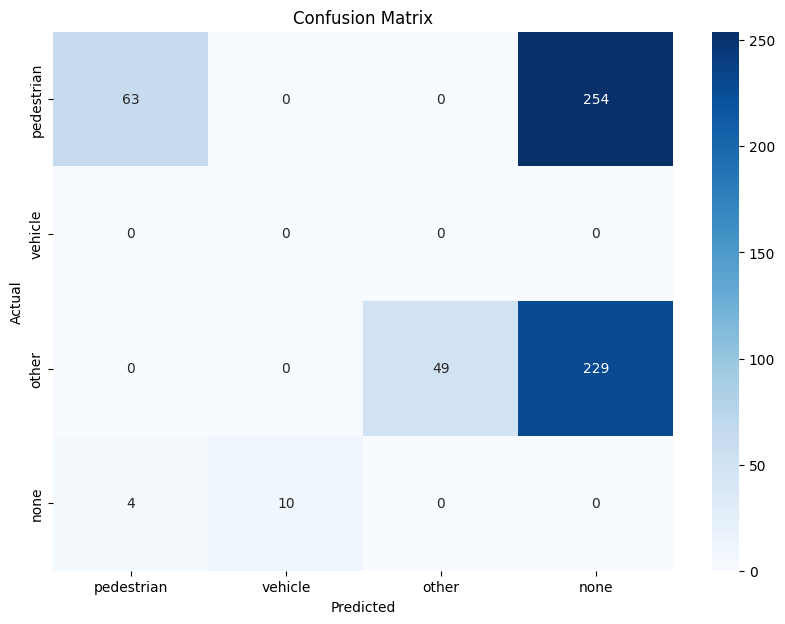

mAP: 0.31


<ipython-input-42-ca92516b335c>:63: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(cm) / np.sum(cm, axis=1)
<ipython-input-42-ca92516b335c>:64: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [42]:
images_dir = './kaggle_pedestrian_dataset.zip (Unzipped Files)/Test/Test/JPEGImages'
annotations_dir = './kaggle_pedestrian_dataset.zip (Unzipped Files)/Test/Test/Annotations'
#evaluate_model(images_dir, annotations_dir, model_name)

#Content of evaluate_model function below for better error spotting
iou_threshold=0.2
images, ground_truths = load_dataset(images_dir, annotations_dir)
compiled_model, H, W, output_layer_ir = load_model(model_name)

y_true = []
y_pred = []

for img_path, img in images:
    height, width, _ = img.shape
    input_image = preprocess(img, H, W)

    # Perform inference
    result = compiled_model([input_image])[output_layer_ir]

    # Post-process the results
    predictions = []
    for res in result[0][0]:
        score = res[2]
        if score > 0.7:
            x1 = int(res[3] * width)
            y1 = int(res[4] * height)
            x2 = int(res[5] * width)
            y2 = int(res[6] * height)
            label = 'vehicle' if res[1] == 1 else 'pedestrian'
            predictions.append((x1, y1, x2, y2, label, score))

    matched_preds, matched_gts = match_predictions_with_ground_truths(predictions, ground_truths[img_path], iou_threshold)

    for gt in ground_truths[img_path]:
        y_true.append(gt[4])
        if gt in matched_gts:
            y_pred.append(gt[4])
        else:
            y_pred.append('none')

    for pred in predictions:
        if pred not in matched_preds:
            y_pred.append(pred[4])
            y_true.append('none')

# Calculate confusion matrix
cm_labels = ['pedestrian', 'vehicle', 'other', 'none']
cm = confusion_matrix(y_true, y_pred, labels=cm_labels)

print(f'Confusion Matrix:\n{cm}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate mAP
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_scores = 2 * (precision * recall) / (precision + recall)
map_value = np.nanmean(f1_scores)
print(f'mAP: {map_value:.2f}')

In [34]:
print(len(y_true))

609


In [36]:

print(len(y_pred))

609


In [37]:
print(all_detections)

[[(33, 88, 192, 256, 'vehicle', 0.9995925), (439, 172, 482, 281, 'pedestrian', 0.7251739)], [], [], [], [], [], [], [], [], [(169, 55, 319, 640, 'pedestrian', 0.9442949)], [(5, 0, 243, 357, 'pedestrian', 0.9875965)], [(-10, -3, 261, 769, 'pedestrian', 0.95832896), (316, 147, 535, 706, 'pedestrian', 0.8327724)], [], [], [], [], [], [(703, -12, 1026, 472, 'pedestrian', 0.7281411)], [], [], [], [], [], [], [], [], [], [], [(0, -13, 219, 721, 'pedestrian', 0.9925323), (318, 78, 472, 655, 'pedestrian', 0.9439132)], [(24, -12, 382, 675, 'pedestrian', 0.8580287)], [(404, 190, 474, 395, 'pedestrian', 0.85927415)], [], [(63, 121, 454, 353, 'vehicle', 0.9807786)], [], [], [], [(336, 1, 500, 317, 'pedestrian', 0.7592139), (14, 80, 122, 341, 'pedestrian', 0.7000705)], [(430, 122, 684, 778, 'pedestrian', 0.7598666)], [], [], [(888, 559, 995, 906, 'pedestrian', 0.8441567)], [(38, 28, 145, 505, 'pedestrian', 0.7352689)], [], [], [(290, 172, 501, 284, 'vehicle', 0.99977654), (254, 144, 292, 270, 'pede

In [38]:
print(all_ground_truths)

[[(244, 154, 264, 241, 'person'), (315, 133, 337, 215, 'person'), (367, 109, 388, 169, 'person'), (415, 164, 460, 270, 'person'), (382, 162, 422, 263, 'person'), (373, 154, 404, 257, 'person'), (436, 175, 485, 288, 'person')], [(72, 102, 223, 304, 'person')], [(315, 209, 851, 916, 'person-like'), (494, 173, 1205, 916, 'person-like')], [(269, 49, 1255, 1416, 'person-like')], [(139, 86, 757, 977, 'person-like')], [(263, 179, 417, 351, 'person'), (303, 110, 427, 241, 'person'), (266, 103, 365, 257, 'person'), (274, 96, 348, 206, 'person'), (217, 103, 280, 192, 'person'), (162, 107, 238, 194, 'person')], [(201, 57, 325, 259, 'person')], [(103, 66, 489, 400, 'person')], [(158, 93, 259, 398, 'person-like'), (314, 103, 399, 375, 'person-like')], [(82, 22, 370, 615, 'person-like')], [(1, 1, 446, 374, 'person')], [(4, 42, 252, 765, 'person-like'), (302, 145, 540, 704, 'person-like'), (544, 215, 687, 642, 'person-like'), (693, 251, 785, 614, 'person-like'), (757, 282, 866, 587, 'person-like'), (

As we can see, the model predicts the person as vehicle with 99% confidence. This shows questionable performance on the model's generalizability.

#Inference on a single image

In [43]:
img_file_path = 'abu-dhabi-pedestrian.jpg'

In [44]:
compiled_model, H, W, output_layer_ir = load_model(model_name)
img = cv2.imread(img_file_path)

In [45]:
# Preprocess the frame
height, width, _ = img.shape
input_image = preprocess(img, H, W)

In [46]:
# Perform inference
result = compiled_model([input_image])[output_layer_ir]

In [47]:
# Post-processing steps here...
x1, y1, x2, y2, det_label, score, color = postprocess(img, model_name, result, height, width)

In [48]:
cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=1)
cv2.putText(img, '{} {:.1%}'.format(det_label, score),
            (x1, y1 - 7), cv2.FONT_HERSHEY_COMPLEX, .5, color=(68, 1, 84), thickness=1)

array([[[234, 239, 240],
        [236, 241, 244],
        [235, 238, 246],
        ...,
        [215, 231, 248],
        [212, 227, 246],
        [210, 227, 246]],

       [[235, 240, 241],
        [236, 241, 244],
        [236, 239, 247],
        ...,
        [214, 230, 247],
        [210, 228, 245],
        [206, 226, 243]],

       [[233, 241, 241],
        [234, 241, 244],
        [234, 240, 245],
        ...,
        [206, 225, 240],
        [201, 222, 237],
        [195, 218, 233]],

       ...,

       [[100, 108, 131],
        [101, 109, 132],
        [102, 110, 133],
        ...,
        [112, 121, 141],
        [112, 121, 141],
        [112, 121, 141]],

       [[102, 109, 129],
        [102, 109, 129],
        [102, 109, 129],
        ...,
        [109, 120, 142],
        [110, 121, 143],
        [111, 122, 144]],

       [[115, 122, 142],
        [114, 121, 141],
        [112, 119, 139],
        ...,
        [114, 125, 147],
        [115, 126, 148],
        [114, 125, 147]]

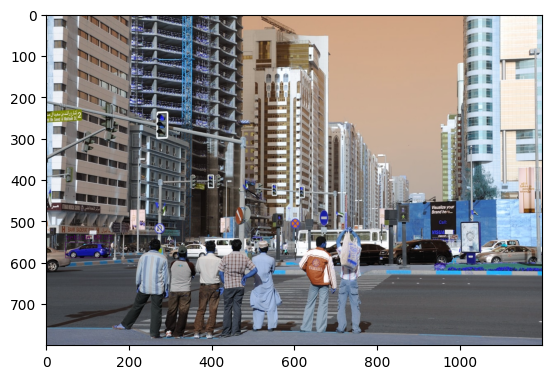

In [49]:
plt.imshow(img)

#Testing on person vehicle bike detection from Open Zoo Models

In [66]:
model_name = 'person-vehicle-bike-detection-crossroad-0078'
img_file_path = 'pedestrian_test_1.jpg'

In [67]:
compiled_model, H, W, output_layer_ir = load_model(model_name)
img = cv2.imread(img_file_path)

In [68]:
# Preprocess the frame
height, width, _ = img.shape
input_image = preprocess(img, H, W)

In [69]:
# Perform inference
result = compiled_model([input_image])[output_layer_ir]

In [70]:
# Post-processing steps here...
x1, y1, x2, y2, det_label, score, color = postprocess(img, model_name, result, height, width)

array([[[185, 197, 197],
        [187, 201, 200],
        [188, 201, 203],
        ...,
        [217, 221, 215],
        [217, 221, 215],
        [217, 221, 215]],

       [[186, 198, 198],
        [187, 201, 200],
        [188, 201, 203],
        ...,
        [217, 221, 215],
        [217, 221, 215],
        [217, 221, 215]],

       [[187, 199, 199],
        [188, 202, 201],
        [189, 202, 204],
        ...,
        [218, 222, 216],
        [218, 222, 216],
        [218, 222, 216]],

       ...,

       [[ 94, 115, 176],
        [ 99, 123, 183],
        [ 89, 119, 178],
        ...,
        [188, 202, 196],
        [186, 200, 194],
        [206, 220, 214]],

       [[ 95, 121, 188],
        [ 99, 127, 192],
        [ 85, 118, 181],
        ...,
        [189, 203, 197],
        [187, 201, 195],
        [202, 216, 210]],

       [[ 87, 111, 177],
        [ 87, 114, 178],
        [ 69, 100, 161],
        ...,
        [192, 206, 200],
        [189, 203, 197],
        [198, 212, 206]]], dtype=uint8)
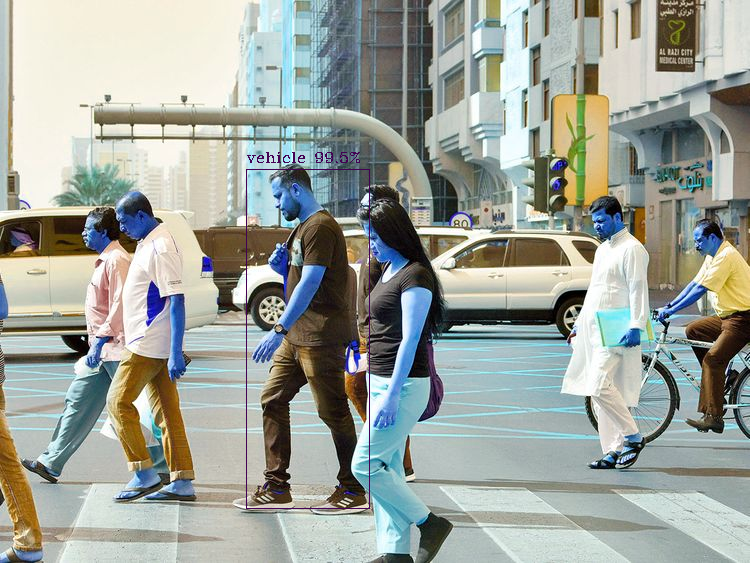

In [71]:
cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=1)
cv2.putText(img, '{} {:.1%}'.format(det_label, score),
            (x1, y1 - 7), cv2.FONT_HERSHEY_COMPLEX, .5, color=(68, 1, 84), thickness=1)

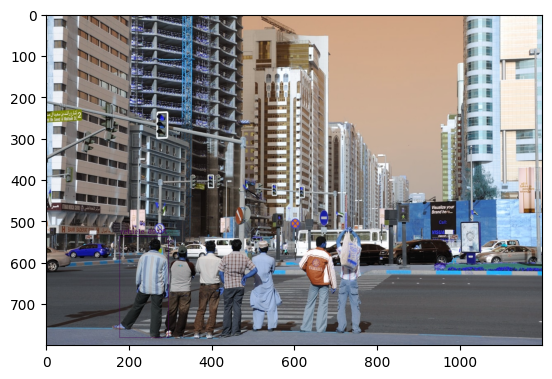

In [57]:
plt.imshow(img)